In [1]:
import pandas as pd
import numpy as np
import numpy.matlib as nm
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
import scipy.io as sio
from scipy.constants import R
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer, RobustScaler
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score, precision_score, recall_score 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.svm import SVC
from mp_api.client import MPRester
import itertools as it
from Functions import *

# 1. Introduction

The dataset contains 10000 different hydrogen adsorption sites from 479 different bi-element intermetallic materials from 29 elements, with different crystal plane(miller indices) and shift values. The target property is the hydrogen adsorption energy of the adsorption sites. 
Each adsorption site is featurized by the  following features:
1. index of miller indices
2. shift value
3. type of adsorption site(top or not)
4. atom infomation of 4 coordinated atoms of the adsorbate, and 8 atoms coordinated to the first 4 neighbors.
   (each atom is encoded by its element group, period, electronegativity and number of unparied d electrons)   

  

**Classification problem**: To build a classifier to predict whether the adsorption site can have a near-optimal hydrogen adsorption energy (i.e. 0.2 eV around the optimal value of -0.27 eV), with satisfactory precision and recall score.

**Regression probelm**: To build a regressor to predict the hydrogen adsorption energy of the adsorption sites from the features set.
 

### 1.0 Importing Data

In [2]:
df = pd.read_csv('simple_fea_10000.csv').drop(columns=['Unnamed: 0'])
df.index = range(len(df))
df = add_chemsys_and_label(df)
print('# of adsorption sites:', len(df),'\n',"type of intermetallic materials:",len(df['mpid'].unique()))
print("Adsorption site with near-optimal adsorption energy",len(df[df['label']==1]))
print("Adsorption site with non-optimal adsorption energy",len(df[df['label']==0]))

Retrieving SummaryDoc documents:   0%|          | 0/479 [00:00<?, ?it/s]

# of adsorption sites: 10000 
 type of intermetallic materials: 479
Adsorption site with near-optimal adsorption energy 4019
Adsorption site with non-optimal adsorption energy 5981


### 1.1 Data Visualization

**Visualized the number of surfaces for each chemical systems**  
The label of xtick and ytick is the element contained in the chemical systems. Each cell represent a bi-element chemical system, the color of which, indictes the number of adsorptions sites of such chemical system in the dataset. Chemical systems that are not contained in the dataset are colored in white. The diagonal cells and the lower triangle are also colored in grey for better visualization.

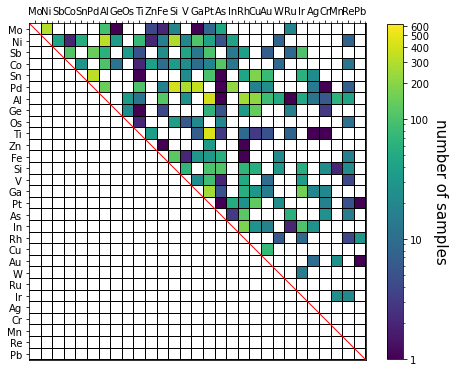

In [3]:
visualize_chemsys_count(df)

The type of miller indics, and the shift values are displayed below. 
The distribution of the target property is visuallized, where the vertical line indicates the boundary for "near-optimal" adsorption energy (±0.2eV around -0.27eV ).

type of miller indices: 31
number of shift values: 952


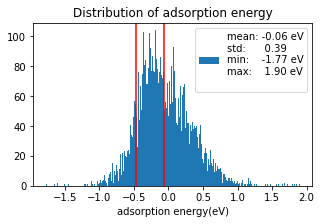

In [4]:
plot_adsorption_energy_distribution(df)

### 1.2 Classification & Regression Problems

The visualization in this section are mainly based on PCA. Given that 1. PCs are just linear combination of the features 2. The feature of closer neighbors are obviously more important (validated in the following sections), the first 2 PCs, which just correpond to features with larger variance, might not be able to show the inherent trend of the data. After considering both the explained variance and importance of features, PC4 and PC6 are selected as the X and Y axis for the visualization.

**Variation Trend :**  
Since the target property (adsorption energy) is the characteristic of how easily can the adsorbate form a weak bond with the surface atoms, it is highly dependent on the local chemical environment, in other words, the atoms species nearby and the structures. The Visualization of fraction of near-optimal surface v.s. chemical components displays that certain chemical systems are just more likely to have a near-optimal adsorption energy (e.g.[Pt,X], [Si,X], [Pd,Ti],etc.), while some sytems are just unfavorable for hydrogen adsorption (e.g.[Au,X], [Ag,X]). (X: random element)

Also, the correlation matrix and the plot of adsorption energy v.s. the group number of coordination atom of the adsorbate shows that the general distribution of the target is asscoiated with the outershell electron configuration of the coordination atoms. e.g. Adsorption sites with group 7 coordination atoms, which have 5 unpaired d electrons, generally have a more negative adsorption energy - more favorable for hydrogen adsorption. Adsorptions sites with group 15 coordination atoms, generall have a more positive adsorption energy - less favorable for hydrogen adsorption.

In [4]:
fea = df.iloc[:,5:].to_numpy()     # exclude the first 4 columns "mpid", "formula","energy" that are not numerical features
scaler = StandardScaler()      # standardize the data
fea = scaler.fit_transform(fea)
n_components = fea.shape[-1] 
print("number of components:", n_components)
pca = PCA(n_components)              # calculate the PCs and the explained variance 
pca.fit(fea)                                                 
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(fea)

number of components: 51


In [5]:
## the top 5 contributing features of the selected PCs
PC_idx_x = np.argsort(abs(pca.components_[3]))[-5:]+5      # find the index of the first 5 most important features
PC_idx_y = np.argsort(abs(pca.components_[5]))[-5:]+5   
print('Top 5 contributing features for PC4:', df.iloc[:,PC_idx_x].keys())
print('Top 5 contributing features for PC6:', df.iloc[:,PC_idx_y].keys())

Top 5 contributing features for PC4: Index(['4group', '6group', '5group', '1upd', '0upd'], dtype='object')
Top 5 contributing features for PC6: Index(['7group', '1period', '6group', '0group', '1group'], dtype='object')


##### 1.2.1 Classification Task

**Visualize the fraction(%) of near-optimal adsorption site for each chemical system**  
The label of xtick and ytick is the element contained in the chemical systems. Each cell represent a two-components chemical system, the color of which, indictes the percentage fraction of the surface with near-optimal adsorption energy. Chemical systems that are not contained in the dataset are colored in grey. The diagonal cells and the lower triangle are also colored in grey for better visualization.

* to be notice, the chemical systems with 100% fraction corresponds to the singel data point chemsys, thus migh not be reliable.

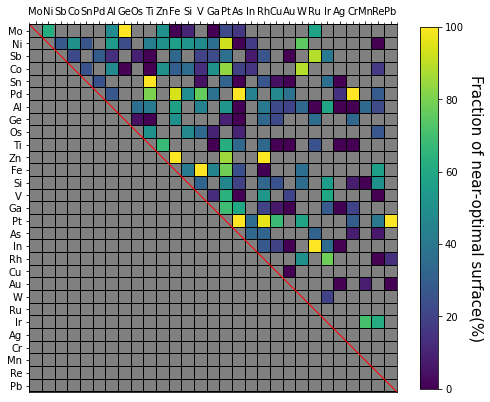

In [8]:
visualize_near_optimal_fraction(df)

Visualize the distribution of two class in the PC space.

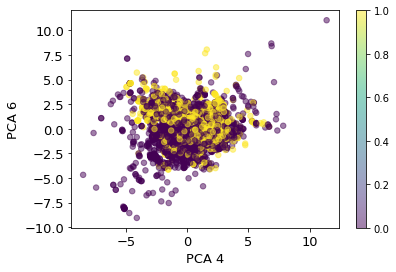

In [9]:
visuaize_label_PCA(pos,df, PC=[3,5])

Display the distribution of two class separately : 
It is oberseved that the near-optimal class are more concentrated in the centre of the PC space, and are much less likely to exist in the lower left corner of the PC space in comparison to the non-optimal class.

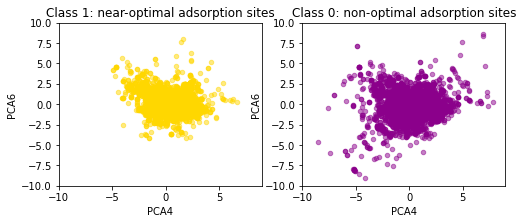

In [10]:
visualize_label_sep_PCA(pos,df, PC=[3,5])

##### 1.2.2 Regression task

Visualize the distribution of target properties in the PC space.

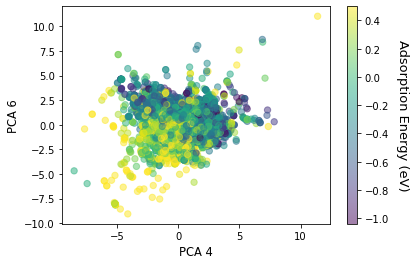

In [6]:
visualize_Ead_PCA(pos,df, PC=[3,5])

Visulize the target distribution w.r.t. the most correlated features

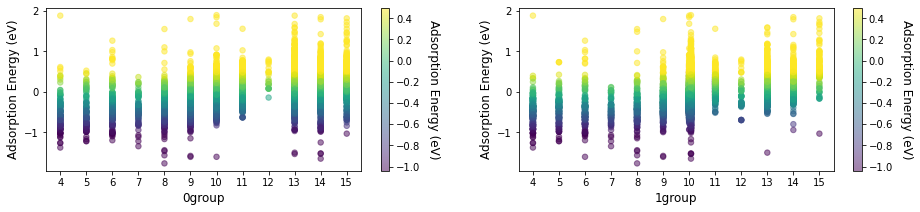

In [7]:
plot_fea_target(df, feature=['0group','1group'])

# 2. Classification - RandomForestClassifier

input datas and target values:

In [8]:
X = df.iloc[:,5:].to_numpy()
y = df['label'].to_numpy()

### 2.1 Hyperparameter Tunning
Hyperparameter tunning is performed by Grid Search+5-fold cross validation. The best parameters are selected to based on the visualization of val AUC and the difference between train & val AUC score to find a balance between the validation performance and overfitting.


Define the hyperparameter sets for grid search

In [9]:
#define tuning hyperparameters
tuned_hyperpar = {'max_depth': [8,12,16,20,24], 'n_estimators': [100,150,200,250]}

# enumerate all combinations of parameters
allpar = sorted(tuned_hyperpar)
combinations = list(it.product(*(tuned_hyperpar[par] for par in allpar)))

Grid search based on random CV

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=40)
AUC_mean_list=[]
AUC_mean_train_list=[]
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[1]

# define a scoring list
i=0
print("Grid search result")
for com in list(combinations):
    par_dict={}
    count=1
    for par_name in reversed(tuned_hyperpar.keys()):
        par_dict[par_name] = com[len(tuned_hyperpar.keys())-count]
        count+=1
    
    #  use Random CV for every combo of parameters
    group_AUC=[]
    group_AUC_train=[]

    for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]

        # create a model for every combo
        RFC = RandomForestClassifier(**par_dict)
        RFC.fit(X_train,y_train)

        # calculate the AUC score for test set
        AUC_train = roc_auc_score(y_train, RFC.predict_proba(X_train)[:, 1])
        AUC = roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1])
        group_AUC.append(AUC)
        group_AUC_train.append(AUC_train)

    AUC_mean=np.mean(group_AUC)
    AUC_std=np.std(group_AUC)
    AUC_mean_list.append(AUC_mean)
    AUC_mean_train_list.append(np.mean(group_AUC_train))
    # print(f"train AUC: {np.mean(group_AUC_train):.3f} +/- {np.std(group_AUC_train):.3f} | val AUC: {AUC_mean:.3f} +/- {AUC_std:.3f} | {par_dict}")

Grid search result


Visualize the result of grid search (validation AUC + difference between train and validation AUC)

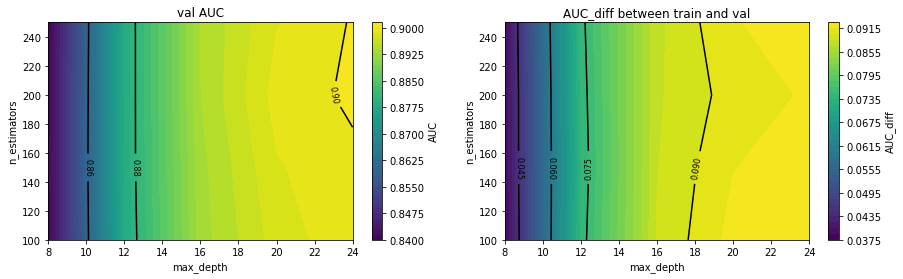

In [11]:
plot_gridsearch_contour_clf(AUC_mean_list, AUC_mean_train_list,tuned_hyperpar)

**The final selected model parameters**

In [12]:
par_dict_final={'max_depth': 12, 'n_estimators': 200}

**Model Generalizability Evaluation:** Perform random CV over the selected hyperparameters and plot the AUC score of val and train sets

In [13]:
# select the best depth and perform the random CV
RFC = RandomForestClassifier(**par_dict_final)
switch = 1
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[switch]

RandomCV_AUC_score_train=[]
RandomCV_AUC_score=[]
RandomCV_RF_misclassified = []
y_hat_CV = np.zeros(len(y))-1

# define a random cross-validation splitter
cv = KFold(n_splits=5, shuffle=True, random_state=40)

for train_index, test_index in cv.split(X):
    X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    RFC.fit(X_train,y_train)
    # Make predictions
    y_test_pred = RFC.predict(X_test)
    y_hat_CV[test_index] = y_test_pred

    misclassified = np.where(y_test != y_test_pred)[0]
    RandomCV_RF_misclassified.append(test_index[misclassified])

    RandomCV_AUC_score_train.append(roc_auc_score(y_train, RFC.predict_proba(X_train)[:, 1]))
    AUC = roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1])
    RandomCV_AUC_score.append(AUC)

RandomCV_RF_misclassified = np.concatenate(RandomCV_RF_misclassified)

Training Avg AUC:  0.952
Validation Avg AUC:  0.878


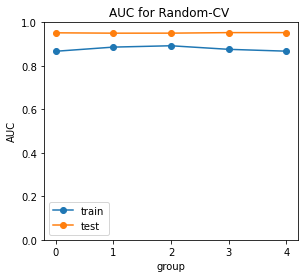

In [14]:
plot_randCV_AUC(RandomCV_AUC_score, RandomCV_AUC_score_train)

### 2.2 Train Full Data Model
train a full-data model with the selected paramters and plot the ROC curve.

Text(0.5, 1.0, 'AUC: 0.937')

<Figure size 216x216 with 0 Axes>

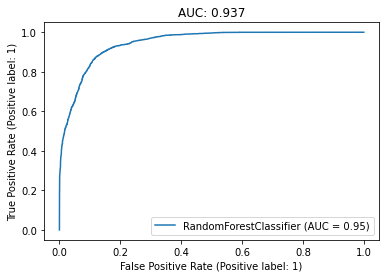

In [8]:
scaler = QuantileTransformer()
X_train, y_train = scaler.fit_transform(X), y 
X_test, y_test = X_train, y_train 

RFC_full = RandomForestClassifier(**par_dict_final)
RFC_full.fit(X_train, y_train)

# predict over the full dataset
y_hat_full = RFC_full.predict(X_test)
AUC = roc_auc_score(y_test, RFC.predict_proba(X_test)[:, 1])
full_RF_misclassified = np.where(y_test != y_hat_full)[0]

# plot the ROC curve
title = 'AUC: ' + str(round(AUC,3))
plt.figure(figsize=(3,3))
plot_roc_curve(RFC_full, X_test, y_test)
plt.title(title)


### 2.3 Model Evaluation  
In this section, the accuracy, precision, recall score are reported for both CV model and the full-data model.  
The classification results are visualized in the form of confusion Matrix and probability distribusion in PC spaces.  
The misclassified region for CV and full-data model are also visualized to explore the material science reason for the model performance.  


Report the accuracy, precision, recall for the CV model and full Data model and plot the confusion matrix

RF_CV accuracy:  0.799
RF_CV precision:  0.75
RF_CV recall score: 0.75 

RFC_full accuracy:  0.877
RFC_full precision:  0.84
RFC_full recall score: 0.857


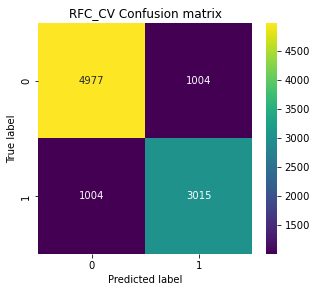

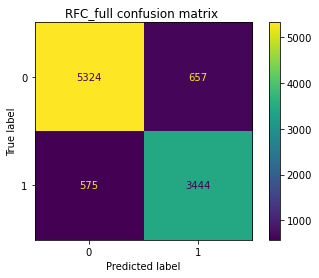

In [10]:
model_eval_clf(RFC_full, y, y_hat_CV, X_test, y_test, y_hat_full)

 Prediction Probability distribusion Plot in PC space

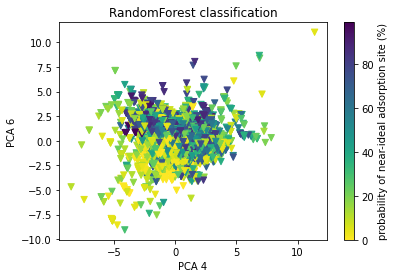

In [11]:
visualize_pred_prob_distribution(RFC_full, X_test, pos, RFC)

Visualize the misclassified results for CV and full-data model in PC space

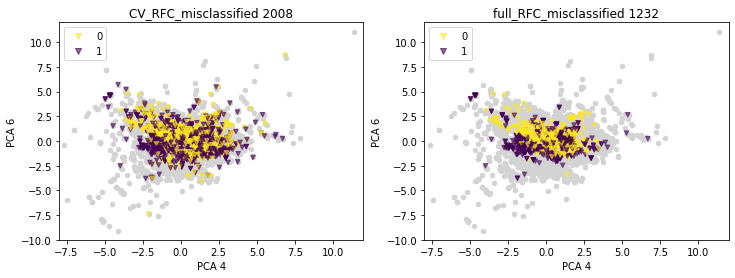

In [12]:
visualize_misclassified_clf_PCA(RandomCV_RF_misclassified, full_RF_misclassified, pos, y, y_test)

Visualize the misclassified datapoints w.r.t the group number of the first(0group) and second(1group) coordination atoms of the adsorbate

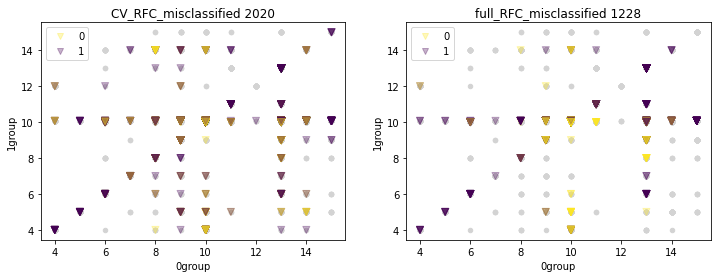

In [12]:
visualize_misclassified_clf_fea(RandomCV_RF_misclassified, full_RF_misclassified, pos, y, y_test, df)

### 2.4 Classification Summary
According to the generalizability evaluation for random CV, the model performance is not great(~0.8 accuracy and ~0.75 precision and recall, which can be attributed to the simplicity of material descriptor. (just the most basic features of elements) Futhermore, from the visualization of misclassified region, the missclassification is highly accociated with the materials systems(e.g. for 0group=1group= 4,5,6,7, the model tends to misclassify the near-optimal adsorption sites). 

A potential reason is the imbalance of datapoints from the material system and the imbalance of the near-optimal/non-optimal ratio for some of the material system. Different chemical systems tends to have a certain trend of adsorption energy. Therefore, for those chemical systems that are naturally imbalance w.r.t near-optimal/ non-optimal (see section 1.2.1 - visualize_near_optimal_fraction), the model might not be able to generalize well.

# 3. Regression - RandomForestRegressor

In [3]:
X = df.iloc[:,5:].to_numpy()
y = df['energy'].to_numpy()

### 3.1 Hyperparameter Tunning
Hyperparameter tunning is performed by Grid Search+5-fold cross validation. The best parameters are selected to based on the visualization of val R2 and the difference between train & val R2 score to find a balance between the validation performance and overfitting.

Define the hyperparameter sets for grid search

In [7]:
import itertools as it

#define tuning hyperparameters
tuned_hyperpar = {'max_depth': [8,12,16,20,24], 'n_estimators': [50,100,150]}

# enumerate all combinations of parameters
allpar = sorted(tuned_hyperpar)
combinations = list(it.product(*(tuned_hyperpar[par] for par in allpar)))

Grid search based on random CV

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=40)
R2_mean_list=[]
R2_mean_train_list=[]
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[0]

# define a scoring list
i=0
print("Grid search result")
for com in list(combinations):
    par_dict={}
    count=1
    for par_name in reversed(tuned_hyperpar.keys()):
        par_dict[par_name] = com[len(tuned_hyperpar.keys())-count]
        count+=1
    
    #  use Random CV for every combo of parameters
    group_R2=[]
    group_R2_train=[]

    for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]

        # create a model for every combo
        RFR = RandomForestRegressor(**par_dict)
        #print(par_dict)
        RFR.fit(X_train,y_train)

        #calculate R2 for train set
        y_hat_train = RFR.predict(X_train)
        R2_train = r2_score(y_train, y_hat_train)
        group_R2_train.append(R2_train)

        #calculate R2 for test set
        y_hat = RFR.predict(X_test)
        R2 = r2_score(y_test, y_hat)
        group_R2.append(R2)

    R2_mean_train=np.mean(group_R2_train)
    R2_std_train=np.std(group_R2_train)
    R2_mean_train_list.append(R2_mean_train)

    R2_mean=np.mean(group_R2)
    R2_std=np.std(group_R2)
    R2_mean_list.append(R2_mean)

    # print(f"{R2_mean_train:0.3f}(+/-{R2_std_train*2:0.03f}) --> {R2_mean:0.3f} (+/-{R2_std*2:0.03f}) for {par_dict}")
    i+=1

Grid search result


Visualize the result of grid search (validation R2 + difference between train and validation R2)

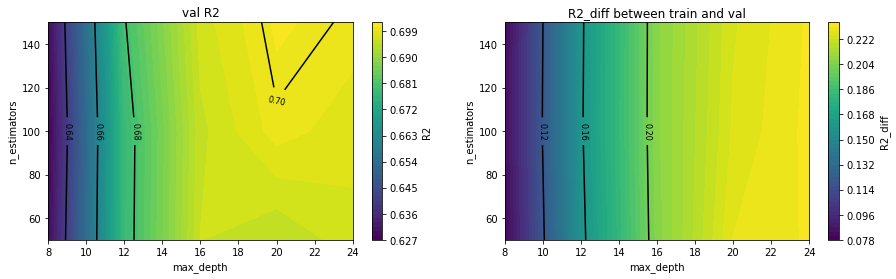

In [18]:
plot_gridsearch_contour_reg(R2_mean_list, R2_mean_train_list, tuned_hyperpar)

**The final selected model parameters**

In [4]:
par_dict_final={'max_depth': 16, 'n_estimators': 150}

**Model Generalizability Evaluation:** Perform random CV over the selected hyperparameters and plot the R2 score of train and val sets

In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=40)
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[0]

group_R2_train = []
group_R2 = []
y_hat_randCV = np.zeros(len(y))-1
std_randCV = np.zeros(len(y))-1
len_count = 0

# create a model for using tuned hyperparameters
RFR_rd = RandomForestRegressor(**par_dict_final)

for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]

        #print(par_dict)
        RFR_rd.fit(X_train,y_train)

        #calculate R2 for train set
        y_hat_train = RFR_rd.predict(X_train)
        R2_train = r2_score(y_train, y_hat_train)
        group_R2_train.append(R2_train)

        #calculate R2 for test set
        y_hat = RFR_rd.predict(X_test)
        R2 = r2_score(y_test, y_hat)
        group_R2.append(R2)

        # store the predicted value
        std_randCV[test_index] = np.std([tree.predict(X_test) for tree in RFR_rd.estimators_], axis=0)
        y_hat_randCV[test_index] = y_hat
        len_count += len(test_index)

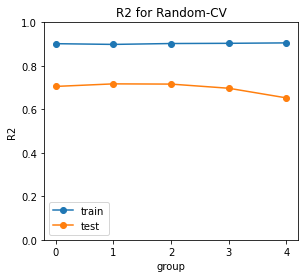

In [18]:
plot_randCV_R2(group_R2, group_R2_train)

### 3.2 Train full data model

In [7]:
X = scaler.fit_transform(X)
RFR_full = RandomForestRegressor(**par_dict_final)
RFR_full.fit(X,y)

#calculate R2 for train set
y_hat = RFR_full.predict(X)
R2 = r2_score(y, y_hat)
std = np.std([tree.predict(X) for tree in RFR_full.estimators_], axis=0)
print(R2)

0.8995193348826088


### 3.3 Model Evaluation

In [26]:
print('---------random CV---------')
mse = mean_squared_error(y, y_hat_randCV)
mape = mean_absolute_percentage_error(y, y_hat_randCV)
mae = mean_absolute_error(y, y_hat_randCV)
print(f"mae: {mae:.3f}, mape: {mape:.3f}, mse: {mse:.3f}",'\n')

print('---------full model---------')
mse = mean_squared_error(y, y_hat)
mape = mean_absolute_percentage_error(y, y_hat)
mae = mean_absolute_error(y, y_hat)
print(f"mae: {mae:.3f}, mape: {mape:.3f}, mse: {mse:.3f}")

---------random CV---------
mae: 0.139, mape: 2.112, mse: 0.045 

---------full model---------
mae: 0.085, mape: 1.556, mse: 0.015


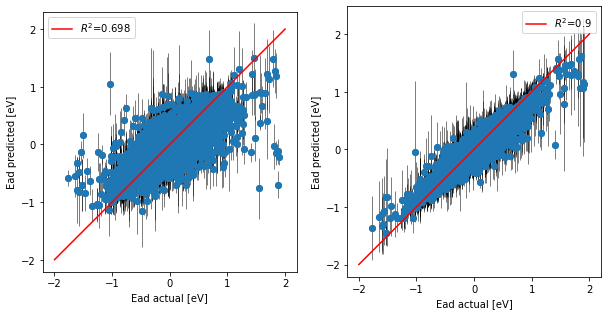

In [8]:
model_eval_reg(y, y_hat, y_hat_randCV, std_randCV, std)

### 3.4 Feature Importance
the top 10 important features and displayed. The importance rank displayed that the property of the first shell coordination atoms dominant the predictive power of the model, especially the group numbers(0 group, 0 period, 1 group, 2group). It make physical sense well, as the those features have a strong correlation to the element outer valence electron configuration, which have a great impact on the adsorption process.

Text(0.5, 1.0, 'Feature importances using MDI')

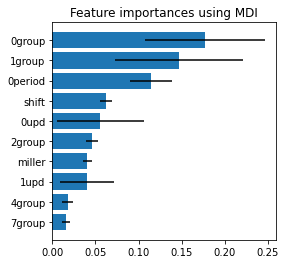

In [42]:
# get importance
importance = RFR_full.fit(X,y).feature_importances_ #using Gini importance implemented by Sklearn (Mean decrease in impurity)
std = np.std([tree.feature_importances_ for tree in RFR_full.estimators_], axis=0)

# plot feature importance
sort = importance.argsort()[-10:]
# reverse sort
plt.figure(figsize=(4, 4))
plt.barh(df.iloc[:,5:].columns[sort], importance[sort], xerr=std[sort])
plt.title("Feature importances using MDI")


# 4. Refinement 

### 4.1 Identify the information rich region in feature space & influential data points

From the material science perspective, the information rich region in feature space would correspond to those **regions dominated by dissimliar material systems**, since we learnt from the previous LOCO examples that ML model cannot learn to predict completely new material systems well. This can be confirmed by the following visualizations in PC space. The colormap of the left plot is the index of 184 chemical systems. The chemical systems are sorted before facotorized into index values, therefore similar systems(containing same elements) would tend to have similar color. From the left plot, a **systematic seperation of different systems** is observed. When comparing with the right plot, which is colored according to the adsorption energy distribution, it is observed that the target distribution well-mixed between different systems. Therefore, the influentials points would be those **data points that can capture more target variance of each dis-similar chemical system/bulk material.**  

# of chemical systems 184


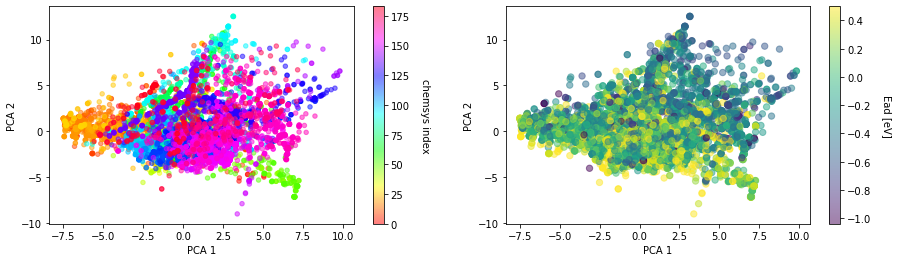

In [30]:
print("# of chemical systems", len(df.chemsys.value_counts()))
visualize_chemsys_target_PCA(df, pos)

### 4.2 Identify the important features
The feature of importance are identified based on the full-data model of the RandomForestRegressor.   
the feature "5 group" & "6 group" are expected to be important from a materials science perspective, therefore the importance of "5 group" is used as the threshold to select the important features, 33 least important features are dropped. 

**The final number of feature retained for furhter analysis is 20.**

Calculate the feature importance based on the full-data model of the RandomForestRegressor

In [27]:
importance = RFR_full.fit(X,y).feature_importances_ #using Gini importance implemented by Sklearn 
std = np.std([tree.feature_importances_ for tree in RFR_full.estimators_], axis=0)

Plot the feature importance of the top 20 features

Text(0.5, 1.0, 'Feature importances using MDI')

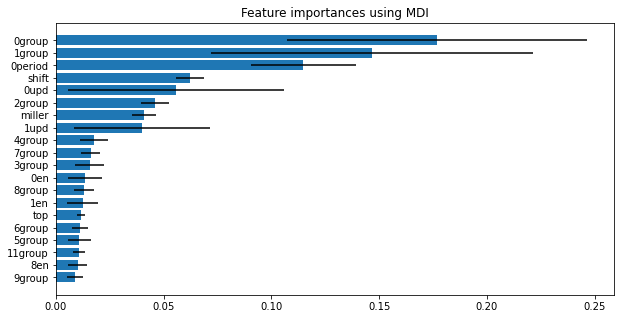

In [43]:
sort = importance.argsort()[-20:]
# reverse sort
plt.figure(figsize=(10,5))
plt.barh(df.iloc[:,5:].columns[sort], importance[sort], xerr=std[sort])
plt.title("Feature importances using MDI")

Drop the un-important features from the dataset

In [44]:
sort = importance.argsort()
df2 = df.copy()
df2 = df2.drop(df2.iloc[:,5:].columns[sort][:31], axis=1)
print("feature dropped: ", df.iloc[:,5:].columns[sort][:31].to_list())

feature dropped:  ['5upd', '8period', '4upd', '3period', '10upd', '3en', '4period', '9period', '10period', '6upd', '5period', '11upd', '6period', '7period', '11period', '2upd', '9upd', '2period', '8upd', '2en', '3upd', '4en', '7upd', '5en', '11en', '1period', '9en', '10en', '7en', '10group', '6en']


### 4.3 Acquisition policy
The acquisition policy is defined as such: for each intermetallic materials, sorted the surface sites from the same bulk by the target value, then the data point are selected from the larget target value point and after a fixed step(= 1/frac of the subset to be trained). The goal is to prior spanning through the target distribution of each bulk material upon sampling. e.g. for mp-10015, there are five datapoint with target = [-0.98,0.21,0.23,0.25,0.37], given fraction = 0.5, the acquisition policy would select the datapoints with target = [-0.98, 0.23, 0.37] into the training set.

In [14]:
def sample_index(df2, frac):
    mpid = df2['mpid'].unique()
    mpid.sort()
    sample_index = []
    for i in range(len(mpid)):
        mp_mat = df2[df2['mpid']==mpid[i]].sort_values(by=['energy'])       # sort the subset of mpid[i] by energy 
        indx = np.array(range(len(mp_mat)))
        selected_index = np.arange(0,len(mp_mat),1/frac)                    # select material index by a constant step
        if selected_index == []:
            selected_index = np.random.choice(indx, 1, replace=False)
            sample_index+=mp_mat.iloc[selected_index,:].index.tolist()
        else:
            sample_index+=mp_mat.iloc[selected_index,:].index.tolist()
    return sample_index


### 4.4 Quantify model performance
In this section, a differenc fraction of the refined dataset(num of fea = 20) is obtained using the 4.3 acquisition policy, to train the classification and regression model. The model performance is then verified over the whole dataset. The result is visualized by ploting the model performance(AUC, mae)) v.s. the fraction of training set. Five-iteration of random sampling is performed for each fraction value for comparison.

##### 4.4.1 Refined Classifier

Quantify the model performance of the refined classifier using systematic sampling

In [ ]:
X = df2.iloc[:,5:].to_numpy()
y = df2['label'].to_numpy()
scaler = QuantileTransformer()

par_dict_final={'max_depth': 12, 'n_estimators': 200}

frac_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
frac_true = []
AUC_train_list = []
AUC_list = []

for frac in tqdm(frac_list):
    train_index = sample_index(df2, frac=frac)
    frac_true.append(len(train_index)/len(df2))
    X_train, y_train = scaler.fit_transform(X[train_index]), y[train_index]

    # create a model for every combo
    RFC = RandomForestClassifier(**par_dict_final, random_state=42)
    RFC.fit(X_train,y_train)

    # calculate the AUC score for test set
    AUC_train = roc_auc_score(y_train, RFC.predict_proba(X_train)[:, 1])
    AUC_train_list.append(AUC_train)

    # calculate the AUC score for test set
    AUC = roc_auc_score(y, RFC.predict_proba(scaler.transform(X))[:, 1])
    AUC_list.append(AUC)

Quantify the model performance of the refined classifier using 5 iterations of random sampling for comparison

In [ ]:
X = df2.iloc[:,5:].to_numpy()
y = df2['label'].to_numpy()
AUC_train_list_rd = []
AUC_list_rd = []

for i in range(5):
    for frac in tqdm(frac_true):
        train_index =  np.random.choice(np.arange(0,len(X)), int(len(X)*frac), replace=False)
        X_train, y_train = scaler.fit_transform(X[train_index]), y[train_index]

        # create a model for every combo
        RFC = RandomForestClassifier(**par_dict_final,random_state=42)
        RFC.fit(X_train,y_train)

        # calculate the AUC score for test set
        AUC_train_rd = roc_auc_score(y_train, RFC.predict_proba(X_train)[:, 1])
        AUC_train_list_rd.append(AUC_train)

        # calculate the AUC score for test set
        AUC = roc_auc_score(y, RFC.predict_proba(scaler.transform(X))[:, 1])
        AUC_list_rd.append(AUC)

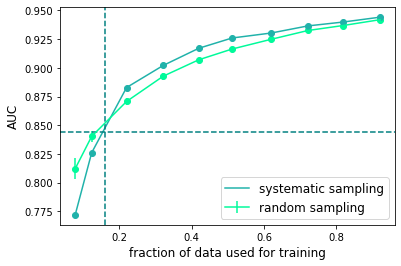

In [48]:
# mean AUC for random sampling with error bar accross 5 runs
plot_AUC_vs_frac(frac_true, AUC_list, AUC_list_rd)

##### 4.4.2 Refined Regressor

Quantify the model performance of the refined regressor using systematic sampling

In [ ]:
# create the model with same sparameters in Section 3.2
par_dict_final={'max_depth': 16, 'n_estimators': 150}

# input feautres and target
X = df2.iloc[:,5:].to_numpy()
y = df2['energy'].to_numpy()
scaler = StandardScaler()

# specify a list of training set sizes
frac_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
frac_true = []
# create lists to store the results
mae_list = []

for frac in tqdm(frac_list):
    train_index = sample_index(df2, frac=frac)
    frac_true.append(len(train_index)/len(df2))
    X_train, y_train= scaler.fit_transform(X[train_index]), y[train_index]

    # fit the model with training set
    RFR = RandomForestRegressor(**par_dict_final, random_state=42)
    RFR.fit(X_train,y_train)

    # predict target value for test set
    y_hat = RFR.predict(scaler.transform(X))

    mae = mean_absolute_error(y, y_hat)
    mae_list.append(mae)


Quantify the model performance of the refined regressor using 5 iterations of random sampling for comparison

In [ ]:
# input feautres and target
X = df2.iloc[:,5:].to_numpy()
y = df2['energy'].to_numpy()

# create lists to store the results
mae_list_rd = []

for i in range(5):
    for frac in tqdm(frac_true):
        train_index =  np.random.choice(np.arange(0,len(X)), int(len(X)*frac), replace=False)
        X_train, y_train= scaler.fit_transform(X[train_index]), y[train_index]

        # fit the model with training set
        RFR = RandomForestRegressor(**par_dict_final, random_state=42)
        RFR.fit(X_train,y_train)

        # predict target value for test set
        y_hat = RFR.predict(scaler.transform(X))

        mae_rd = mean_absolute_error(y, y_hat)
        mae_list_rd.append(mae_rd)

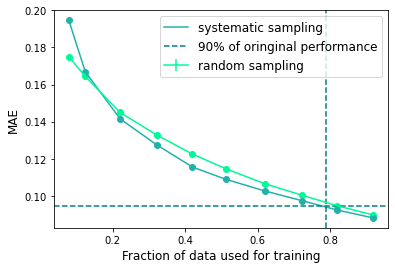

In [52]:
# mean MAE for random sampling with error bar accross 5 runs
plot_mae_vs_frac(frac_true, mae_list, mae_list_rd)

**Task 2 Summary:**  
**Disucssion of the trend observed:**
In general, it is confirmed that acquisition policy increases the model predictive power faster than random sampling. Though, at very low fraction, the acquisition policy always perform worse than the random sampling, it can be explained by that, when the step is too large, it tends to pick the data with max and min value of the material subset, which is not representative and could be outliers from the DFT calcualtion error, therefore leading to a poor prediction performance. However, when the fraction is larger, the acquisition policy can stably outperform the random sampling. When the fraction continue approaching 1, where most of the testing data are seen by the model already, acquisition policy would not make significant difference.

For the **classification**, the model can reach 90% AUC of the full datamodel(90%* 0.938=0.8442) with 16% dataset, which displayed that simply knwoing the element species near the adsorbate can provide information about the catalytic performance of the surface.

For the **regression**, 79%, a much larger fraction, of original dataset is required to reach 110% MAE of the full data model(110%*0.085=0.094, which is expected considering the inherent complexity of the task: directly related the exact adsorption energy value to such simple descriptor. 

The result overall confirmed my hypothesis about the influential data points, showing the importance of making surfaces as diversed as possible while generating structures from the same chemical system in such kind of research 
